# Breast Cancer Survival Time after Diagnosis  
####  Random Forest Regression on Log Odds of Survival Time

Data source:  U.S. Department of Health and Human Services, National Institutes of Health, National Cancer Institute  
Surveillance, Epidemiology, and End Results (SEER) Program - Incidences of Breast Cancer  
https://seer.cancer.gov/ 

#### Purpose  
The purpose of this analysis is the determine the factors that contribute to mortality after a breast cancer diagnosis. Such analysis will be used uncover treatment strategies and provide a baseline for effectiveness.  

#### Summary 
Breast cancer survival data, as log odds of survival, and patient and neoplasm characteristics were  fitted using the random forest method. Ultimately the analysis showed that the independent variables have low explanatory power for the dependent variable, coefficient of determination of 0.3.  

In [1]:
%matplotlib inline

# Standard Module set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Statistical analysis and regression
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

C:\Users\rgorh\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Data set  
The data set has been formatted and cleaned, then read into a csv file. Many of the independent variables are categorical, dummy variables were constructed to ease analysis. The data set contains patient by patient data, covering survival times, some basic patient and neoplasm characteristics. The variables are:  
srv_time_mon - Main dependent variable. Number of months the patient survives after a diagnosis.  
p_srv - Constructed from  the depenedent variable, the probability of survival after a diagnosis.  
c_srv - Constructed from the dependent variable, the count of patients surviving to the time point.  
log_odds - An alternate dependent variable and constructed from the dependent variable, the log odds of the patient survival after a diagnosis.  
REG - Independent variable, the US region where the diagnosis occurred.  
MAR_STAT - Independent variable, marital status of the patient.  
RACE1V - Independent variable, ethnicity of the patient.   
NHIADE - Independent variable, for hispanic ethnicities, further classifications.  
SEX - Independent variable, gender of the patient.  
AGE_DX - Independent variable, age of the patient at diagnosis.  
SEQ_NUM - Independent variable, number of previous diagnoses.   
LATERAL - Independent variable, side of body of the diagnosis.  
HISTO3V - Independent variable, histologic characteristics of the diagnosis.   
BEHO3V - Independent variable, behvior characterization of the neoplasm.  
GRADE - Independent variable, a classification of the severity of the neoplasm.  
HST_STGA - Independent variable, histologic stage of the neoplasm.  
MALIGCOUNT - Independent variable, the number of malignant neoplasms at diagnosis.  
BENBORDCOUNT - Independent variable, the number of benign neoplasms at diagnosis.  
PRIMSITE_coded - Independent variable, the primary site of the diagnosis.  
           
           

In [2]:
#Dataset that has been organized and formatted,
cancer_sruviv = pd.read_csv('./data/dummied.csv')

#Remove old index
cancer_sruviv = cancer_sruviv.drop('Unnamed: 0', axis=1)

In [3]:
#Split train and test sets
train, test = train_test_split(cancer_sruviv)

#### Analysis  
Though the coefficient of determination is relatively high, when the out of bag samples are analyzed the coefficient is significantly lower, indicating over fitting. Further analysis was performed with maximum depth and the number of estimators to reduce over fitting. Other models may show improvement.

In [4]:
#Set up data for analysis and perform radom forest regression
x = train.drop(['srv_time_mon', 'p_srv', 'c_srv', 'log_odds'], axis=1)
y = train.log_odds

model = RandomForestRegressor(n_estimators=150, max_features='sqrt',
                                    oob_score=True).fit(x, y)

In [5]:
#Model analysis
print(f'Coefficient of determination of the model: {np.round(model.score(x, y),2)}\n'
      f'Coefficient of determination of out of bag samples: {np.round(model.oob_score_ ,2)}')

Coefficient of determination of the model: 0.83
Coefficient of determination of out of bag samples: 0.22


#### Residuals  
The distribution of residuals show deviation from normal and possible heteroskedasticity (against fitted values). The training set and testing set look similar.  Check for correct model specification. 

In [6]:
#Fit training factors and perform some residual analysis
y_pred = model.predict(x)
resid = y_pred - y
resid_stand = (resid.mean() - resid) / resid.std()

ks = stats.kstest(resid_stand, 'norm')[1]
rsd = np.round(np.sqrt(np.sum(resid**2) / (len(resid) - len(x.columns))) ,2)
rrse = np.round(np.sqrt(np.sum(resid**2) / np.sum((y.mean() - y)**2)), 2)
print(f'Residual sd: {rsd}\n'
      f'Relative root residual error:  {rrse}\n'
      f'KS test for normal residual distribution: '
      f'{ks}')

Residual sd: 0.71
Relative root residual error:  0.41
KS test for normal residual distribution: 2.60729254654637e-171


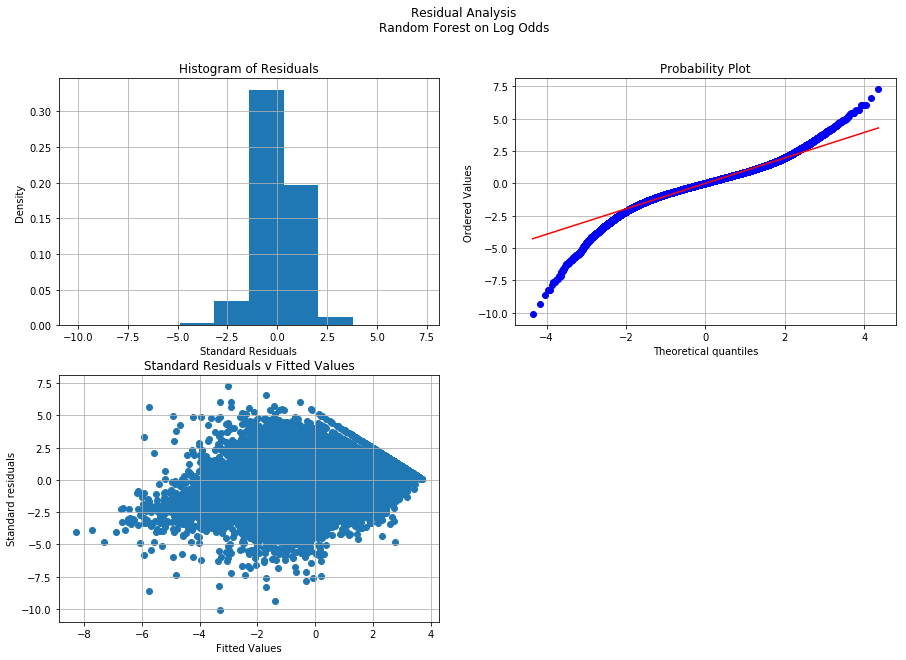

In [7]:
#Plot residuals
plt.figure(figsize=(15,10))
plt.suptitle('Residual Analysis\nRandom Forest on Log Odds')

ax1 = plt.subplot(221)
plt.hist(resid_stand, density=True)
plt.title('Histogram of Residuals')
plt.xlabel('Standard Residuals')
plt.ylabel('Density')
plt.grid()

ax2 = plt.subplot(222)
plot = stats.probplot(resid_stand, plot=plt)
plt.grid()

ax3= plt.subplot(223)
plt.scatter(y_pred, resid_stand)
plt.title('Standard Residuals v Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Standard residuals')

plt.grid()


plt.savefig('./images/fig_1_random_forest.png', transparent=True)

plt.show()


In [8]:
#For heteroskedasticity analysis independent variables vs residuals
# for i in enumerate(x.columns):
#     plt.figure(figsize=(15,(np.floor(len(x.columns)/2)+1)*5))
#     plt.subplot(np.floor(len(x.columns)/2)+1,2,i[0]+1)
#     plt.scatter(x[i[1]], resid_stand)
#     plt.title(f'Residuals to {i[1]}')
#     plt.ylabel('Standardized Residuals')
#     plt.xlabel(f'{i[1]} values')
#     plt.grid()
#     plt.show()

In [9]:
#Predict the training set with the random forest
x_test = test.drop(['srv_time_mon', 'p_srv', 'c_srv', 'log_odds'], axis=1)
y_test = test.log_odds

y_pred_test = model.predict(x_test)
resid_test = y_pred_test - y_test
resid_stand_test = (resid_test.mean() - resid_test) / resid_test.std()

ks = stats.kstest(resid_test, 'norm')[1]
rsd = np.round(np.sqrt(np.sum(resid_test**2) / (len(resid_test) - len(x_test.columns))) ,2)
rrse = np.round(np.sqrt(np.sum(resid_test**2) / np.sum((y_test.mean() - y_test)**2)), 2)
print(f'Residual sd: {rsd}\n'
      f'Relative root residual error:  {rrse}\n'
      f'KS test for normal residual distribution: '
      f'{ks}')

Residual sd: 1.52
Relative root residual error:  0.88
KS test for normal residual distribution: 1.381402367963074e-256


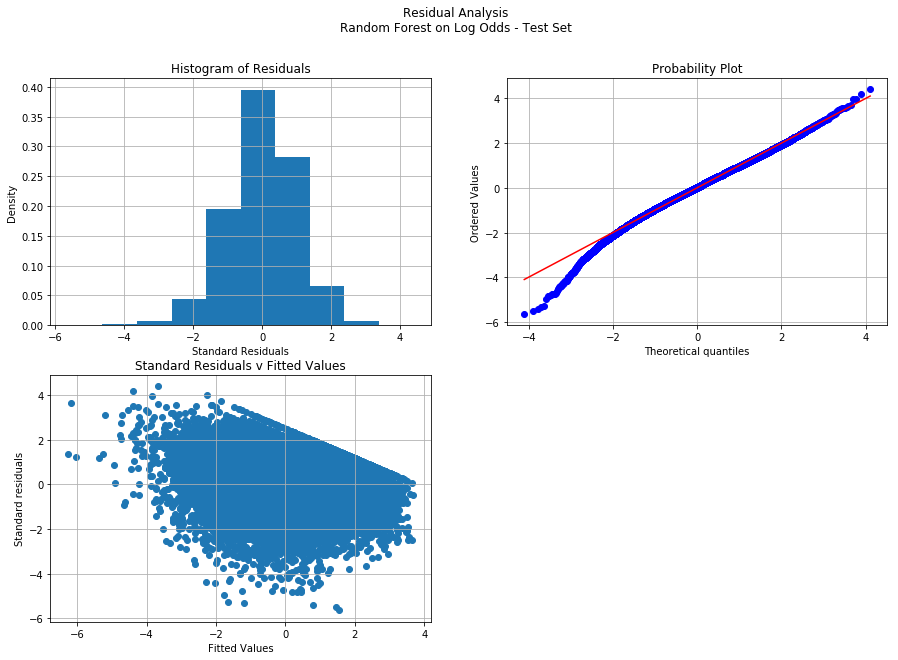

In [25]:
#Plot residuals
plt.figure(figsize=(15,10))
plt.suptitle('Residual Analysis\nRandom Forest on Log Odds - Test Set')

ax1 = plt.subplot(221)
plt.hist(resid_stand_test, density=True)
plt.title('Histogram of Residuals')
plt.xlabel('Standard Residuals')
plt.ylabel('Density')
plt.grid()

ax2 = plt.subplot(222)
plot = stats.probplot(resid_stand_test, plot=plt)
plt.grid()

ax3= plt.subplot(223)
plt.scatter(y_pred_test, resid_stand_test)
plt.title('Standard Residuals v Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Standard residuals')

plt.grid()

plt.savefig('./images/fig_2_random_forest.png', transparent=True)

plt.show()

In [11]:
#For heteroskedasticity analysis independent variables vs residuals
# for i in enumerate(x_test.columns):
#     plt.figure(figsize=(15,(np.floor(len(x_test.columns)/2)+1)*5))
#     plt.subplot(np.floor(len(x_test.columns)/2)+1,2,i[0]+1)
#     plt.scatter(x_test[i[1]], resid_stand_test)
#     plt.title(f'Residuals to {i[1]}')
#     plt.ylabel('Standardized Residuals')
#     plt.xlabel(f'{i[1]} values')
#     plt.grid()
#     plt.show()

#### Random Forest parameter analysis  
The model above was fitted with the default maximum depth. The tree depth ranged from 60 to 80. Further analysis determined that the optimal maximum depth is around 10 to reduce over fitting.

In [12]:
#Function to walk through the random forest
# def dectree_max_depth(tree):
#     n_nodes = tree.node_count
#     children_left = tree.children_left
#     children_right = tree.children_right

#     def walk(node_id):
#         if (children_left[node_id] != children_right[node_id]):
#             left_max = 1 + walk(children_left[node_id])
#             right_max = 1 + walk(children_right[node_id])
#             return max(left_max, right_max)
#         else: # leaf
#             return 1

#     root_node_id = 0
#     return walk(root_node_id)


In [13]:
#Generator to find max_depth of tress
# [dectree_max_depth(tree.tree_) for tree in model.estimators_]

In [14]:
# a = list()
# for i in range(5,80, 5):
#     for j in range(5, 100, 5):
#         model_2 = RandomForestRegressor(n_estimators=j, max_depth = i,max_features='sqrt',
#                                     oob_score=True).fit(x,y)
#         b = [i, j, model_2.score(x,y), model_2.oob_score_]
#         a.append(b)
#         print(i,j,model_2.score(x,y))
#         print(i,j,model_2.oob_score_ )
    


In [15]:
# df = pd.DataFrame(a, columns = ['max_depth', 'n_estimators', 
#                                 'model_score', 'oob_score'])
# df['spread'] = df['model_score'] - df['oob_score']


In [16]:
# for i in df.n_estimators:
#     plt.plot(df[df['n_estimators'] == i]['max_depth'], 
#              df[df['n_estimators'] == i]['spread'], label = i)
# plt.title('Spread of Regression Score\n'
#           'Difference of Random Forest and Out of Bag\n'
#           'by Max Depth of Number of Estimators')
# plt.xlabel('Max Depth')
# plt.ylabel('Spread of Scores')
# plt.grid()
# plt.savefig('./images/fig_random_forest_analysis.png', transparent=True)
# plt.show()

#### Model with limited depth  
The model was re-fitted limiting the maximum depth to 10 to reduce over fitting.  

In [17]:
model_2 = RandomForestRegressor(n_estimators=150, max_depth=10,
                                max_features='sqrt', oob_score=True).fit(x, y)

In [18]:
print(f'Coefficient of determination of the model: {np.round(model_2.score(x, y),2)}\n'
      f'Coefficient of determination of out of bag samples: {np.round(model_2.oob_score_ ,2)}')

Coefficient of determination of the model: 0.31
Coefficient of determination of out of bag samples: 0.3


In [19]:
#Fit training factors and perform some residual analysis
y_pred_2 = model_2.predict(x)
resid_2 = y_pred_2 - y
resid_stand_2 = (resid_2.mean() - resid_2) / resid_2.std()

ks = stats.kstest(resid_stand_2, 'norm')[1]
rsd = np.round(np.sqrt(np.sum(resid_2**2) / (len(resid_2) - len(x.columns))) ,2)
rrse = np.round(np.sqrt(np.sum(resid_2**2) / np.sum((y.mean() - y)**2)), 2)
print(f'Residual sd: {rsd}\n'
      f'Relative root residual error:  {rrse}\n'
      f'KS test for normal residual distribution: '
      f'{ks}')

Residual sd: 1.44
Relative root residual error:  0.83
KS test for normal residual distribution: 7.835617244959612e-45


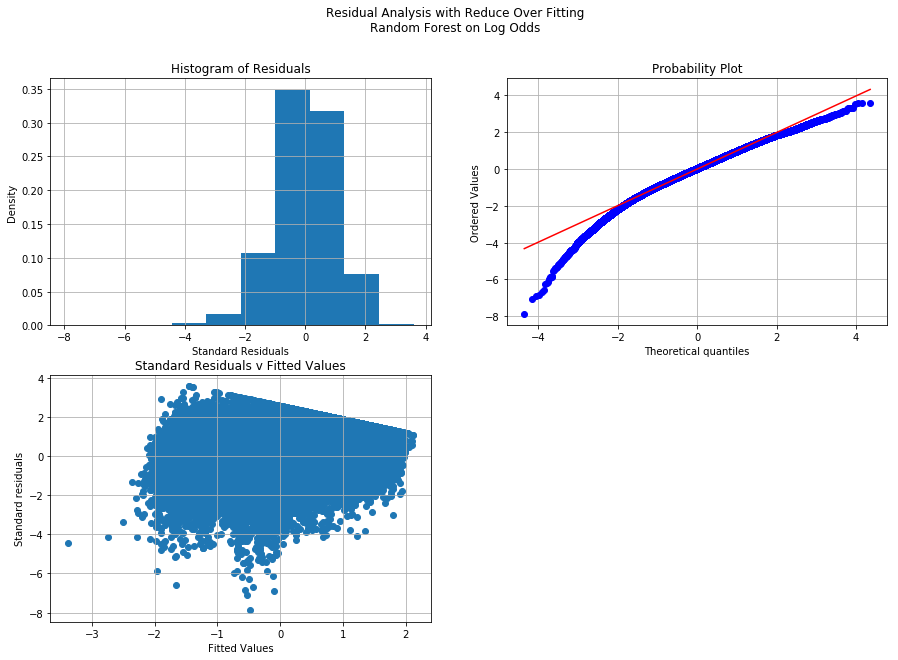

In [20]:
#Plot residuals
plt.figure(figsize=(15,10))
plt.suptitle('Residual Analysis with Reduce Over Fitting\nRandom Forest on Log Odds')

ax1 = plt.subplot(221)
plt.hist(resid_stand_2, density=True)
plt.title('Histogram of Residuals')
plt.xlabel('Standard Residuals')
plt.ylabel('Density')
plt.grid()

ax2 = plt.subplot(222)
plot = stats.probplot(resid_stand_2, plot=plt)
plt.grid()

ax3= plt.subplot(223)
plt.scatter(y_pred_2, resid_stand_2)
plt.title('Standard Residuals v Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Standard residuals')

plt.grid()


plt.savefig('./images/fig_3_random_forest.png', transparent=True)

plt.show()


In [21]:
x_test = test.drop(['srv_time_mon', 'p_srv', 'c_srv', 'log_odds'], axis=1)
y_test = test.srv_time_mon
print(f'Coefficient of determination: {np.round(model.score(x_test, y_test), 2)}')

Coefficient of determination: -1.03


In [22]:
#Predict the training set with the random forest


y_pred_test_2 = model.predict(x_test)
resid_test_2 = y_pred_test - y_test
resid_stand_test_2 = (resid_test_2.mean() - resid_test_2) / resid_test_2.std()

ks = stats.kstest(resid_test_2, 'norm')[1]
rsd = np.round(np.sqrt(np.sum(resid_test_2**2) / (len(resid_test_2) - len(x_test.columns))) ,2)
rrse = np.round(np.sqrt(np.sum(resid_test_2**2) / np.sum((y_test.mean() - y_test)**2)), 2)
print(f'Residual sd: {rsd}\n'
      f'Relative root residual error:  {rrse}\n'
      f'KS test for normal residual distribution: '
      f'{ks}')

Residual sd: 102.83
Relative root residual error:  1.42
KS test for normal residual distribution: 0.0


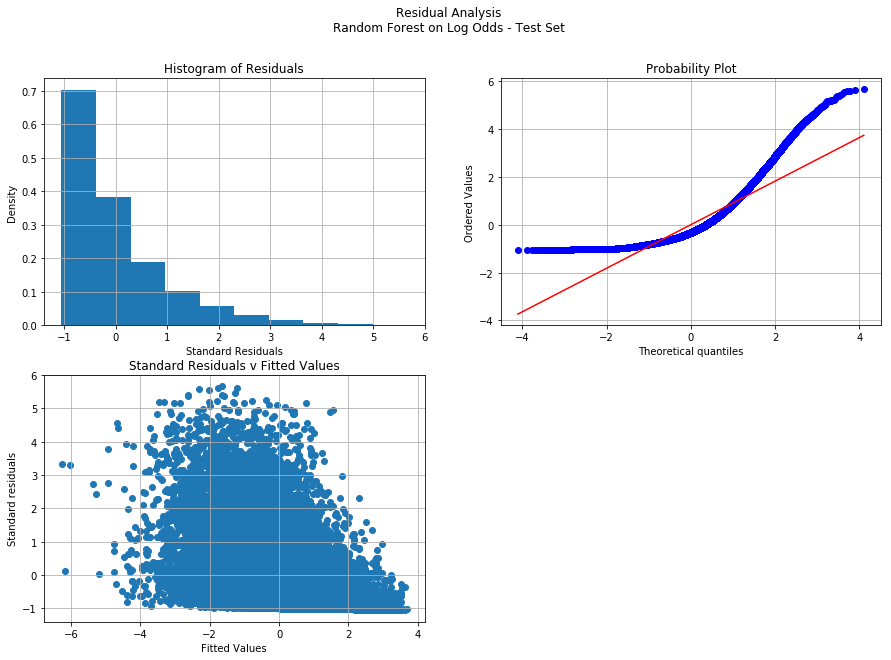

In [26]:
#Plot residuals
plt.figure(figsize=(15,10))
plt.suptitle('Residual Analysis\nRandom Forest on Log Odds - Test Set')

ax1 = plt.subplot(221)
plt.hist(resid_stand_test_2, density=True)
plt.title('Histogram of Residuals')
plt.xlabel('Standard Residuals')
plt.ylabel('Density')
plt.grid()

ax2 = plt.subplot(222)
plot = stats.probplot(resid_stand_test_2, plot=plt)
plt.grid()

ax3= plt.subplot(223)
plt.scatter(y_pred_test_2, resid_stand_test_2)
plt.title('Standard Residuals v Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Standard residuals')

plt.grid()

plt.savefig('./images/fig_4_random_forest.png', transparent=True)

plt.show()